In [9]:
import icarogw
import matplotlib.pyplot as plt
import corner
import numpy as np
import pickle
import h5py
import pickle

# Generating mass and redshift populations

This section serves as an introduction to the different mass distributions. 

### We ask you to do the following: 

Generate a population of BBHs from a powerlaw+gaussian with the following parameters 

```
dic_param = {'alpha':2.,'beta':0.,'mmin':5.,'mmax':65.,'mu_g':35.,'sigma_g':5,'lambda_peak':0.3,'delta_m':3}
```

And generate their redshift from a powerlaw distribution in redshift with parameters at maximum redshift 1.0

```
{'gamma':2.7}
```

Use a cosmology with $H_0=70 \,{\rm km/Mpc/s}$ and convert the source masses and redshift to detector masses and luminosity distance using the functions in the conversions module.

* Histogram the detector masses and luminosity distance
* Assume that you are able to detect events up to 3 Gpc. Find in your list of events all the ones that you can detect and histogram their distribution
* Repeat the previous points using different values of H0. What can you observe from the distributions of detector masses and luminosity distance for all the binaries and the ones that you can detect? Can you motivate it?
* EXTRA: Play with redshift and mass distributions to see how the BBHs distributions change.

/Users/leyde/miniconda3/envs/icarogw/lib/python3.8/site-packages/icarogw-1.0.5-py3.8.egg/icarogw/priors/custom_math_priors.py:48: RuntimeWarning: overflow encountered in exp
/Users/leyde/miniconda3/envs/icarogw/lib/python3.8/site-packages/icarogw-1.0.5-py3.8.egg/icarogw/priors/custom_math_priors.py:161: RuntimeWarning: divide by zero encountered in log
/Users/leyde/miniconda3/envs/icarogw/lib/python3.8/site-packages/icarogw-1.0.5-py3.8.egg/icarogw/priors/custom_math_priors.py:159: RuntimeWarning: divide by zero encountered in log
/Users/leyde/miniconda3/envs/icarogw/lib/python3.8/site-packages/icarogw-1.0.5-py3.8.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/Users/leyde/miniconda3/envs/icarogw/lib/python3.8/site-packages/icarogw-1.0.5-py3.8.egg/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
/Users/leyde/miniconda3/envs/icarogw/lib/python3.8/site-packages/icarogw-1.0.5-py3.8.egg/icarogw/priors/redshift.py:82: Runti

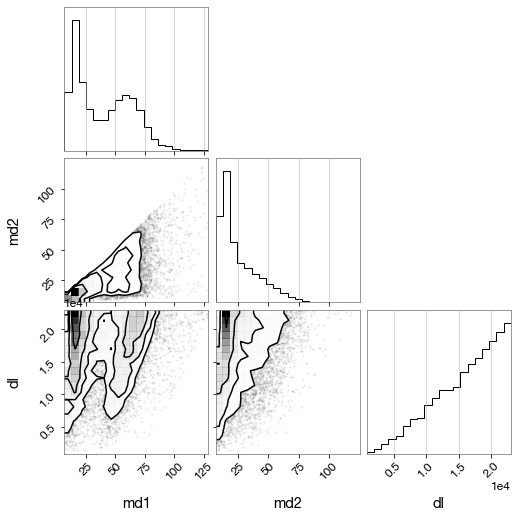

In [10]:
dic_param = {'alpha':2.,'beta':0.,'mmin':5.,'mmax':65.,'mu_g':35.,
                    'sigma_g':5,'lambda_peak':0.3,'delta_m':3}


# Initialize the mass prior
mp = icarogw.priors.mass.mass_prior('BBH-powerlaw-gaussian',hyper_params_dict=dic_param)
ms1,ms2=mp.sample(10000)

cosmo=icarogw.cosmologies.flatLCDM(H0=20,Omega_m=0.308,zmax=1.)
zp = icarogw.priors.redshift.redshift_prior(cosmo,'powerlaw',{'gamma':2.7})
zs=zp.sample(10000)

md1,md2,dl=icarogw.utils.conversions.source_frame_to_detector_frame(cosmo,ms1,ms2,zs)

_=corner.corner(np.column_stack([md1,md2,dl]),labels=['md1','md2','dl'])


# Estimating the selection effect

When working with LVK data and calculating the population parameters of our observed signals, we are subject to selection effects: Not all events of astrophysical origin are recognized as such. 
To evaluate this effects, we have to use the so called $\textit{injection set}$. One generates fake signals in noise and labels them as either detected or undetected, dependent on some criterion. Thankfully, the LVK collaboration offers such labeled lists, which we want to load and use here. 

### We want you to :

Load the injection set from O1 and O2 using pickle

```
inj=pickle.load(open('O1_O2_tutorial.inj','rb'))
```

* Update the SNR cut to 10 and compute the selection effect, expected number of detections for the same mass distribution and redshift distribution of the previous excercise, what numbers do you get?
* Repeat the previous point but varying the Hubble constant. Plot the two quantities as a function of $H_0$, how they are changing? Can you motivate why?
* Check if the selection effect goes as $H_0^3$
* EXTRA: Do the same but with the position of the gaussian peak.

Selecting injections with SNR 7.000000 and IFAR 0.000000 yr


/Users/leyde/miniconda3/envs/icarogw/lib/python3.8/site-packages/icarogw-1.0.5-py3.8.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/Users/leyde/miniconda3/envs/icarogw/lib/python3.8/site-packages/icarogw-1.0.5-py3.8.egg/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
/Users/leyde/miniconda3/envs/icarogw/lib/python3.8/site-packages/icarogw-1.0.5-py3.8.egg/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log


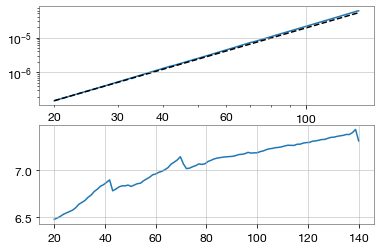

In [11]:
inj=pickle.load(open('O1_O2_tutorial.inj','rb'))
inj.update_cut(snr_cut=7.,ifar_cut=0.)
H0_array=np.linspace(20,140,100)
sel=np.zeros_like(H0_array)
Nexp=np.zeros_like(H0_array)



for i,H0 in enumerate(H0_array):
    cosmo=icarogw.cosmologies.flatLCDM(H0=H0)
    zp = icarogw.priors.redshift.redshift_prior(cosmo,'powerlaw',dic_param={'gamma':2.7})
    mass_hp = {'alpha':2.4,'beta':0,'mmin':5,'mmax':80}
    mp = icarogw.priors.mass.mass_prior(name='BBH-powerlaw',hyper_params_dict=mass_hp)
    inj.update_VT(mp,zp)
    sel[i]=inj.gw_only_selection_effect()
    Nexp[i]=inj.expected_number_detection(20)


fig,ax=plt.subplots(2,1)
ax[0].loglog(H0_array,sel)
ax[0].loglog(H0_array,(sel[0]/H0_array[0]**3)*H0_array**3,ls='--',color='k')

ax[1].plot(H0_array,Nexp)

# Plotting the detected distribution 

To gain a more physical understanding of the observed distribution, we can use our injection set to generate some GW signals. The resulting distribution depends on the redshift and mass model we assume. 

Compare how the observed mass distribution changes with the Hubble constant. Does the maximal luminosity distance at which we see events change? Is this behavior to be physically expected? 

/Users/leyde/miniconda3/envs/icarogw/lib/python3.8/site-packages/icarogw-1.0.5-py3.8.egg/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
/Users/leyde/miniconda3/envs/icarogw/lib/python3.8/site-packages/icarogw-1.0.5-py3.8.egg/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
/Users/leyde/miniconda3/envs/icarogw/lib/python3.8/site-packages/icarogw-1.0.5-py3.8.egg/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log


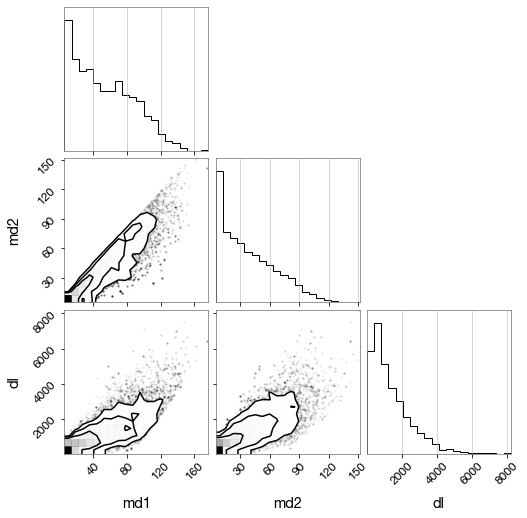

In [12]:
#set a cosmology
cosmo=icarogw.cosmologies.flatLCDM(H0=90,Omega_m=0.308,zmax=1.)

#choose a redshift prior
zp = icarogw.priors.redshift.redshift_prior(cosmo,'powerlaw',dic_param={'gamma':2.7})

#choose a mass model
mass_hp = {'alpha':2.4,'beta':0,'mmin':5,'mmax':80}
mp = icarogw.priors.mass.mass_prior(name='BBH-powerlaw',hyper_params_dict=mass_hp)

#apply the mass and redshift distribution to the injection set
inj.update_VT(mp,zp)

#calculate the observed events
ms1_obs,ms2_obs,z_obs,_,_ = inj.return_reweighted_injections(10000)

#convert them into detector frame 
md1_obs,md2_obs,dl_obs = icarogw.utils.conversions.source_frame_to_detector_frame(cosmo,ms1_obs,ms2_obs,z_obs)

#plot the resulting distribution
fig=corner.corner(np.column_stack([md1_obs,md2_obs,dl_obs]),labels=['md1','md2','dl'])


# Downloading the posterior samples

Maybe this is not needed? 

In [13]:
# Get the posterior samples, please uncomment these lines
# !wget https://dcc.ligo.org/public/0157/P1800370/005/GW150914_GWTC-1.hdf5
# !wget https://dcc.ligo.org/public/0157/P1800370/005/GW151226_GWTC-1.hdf5
# !wget https://dcc.ligo.org/public/0157/P1800370/005/GW170104_GWTC-1.hdf5
# !wget https://dcc.ligo.org/public/0157/P1800370/005/GW170608_GWTC-1.hdf5
# !wget https://dcc.ligo.org/public/0157/P1800370/005/GW170809_GWTC-1.hdf5
# !wget https://dcc.ligo.org/public/0157/P1800370/005/GW170814_GWTC-1.hdf5